
# 🖼️ 이름만으로 만드는 **축제 포스터 배경** (Replicate · FLUX)
- **입력:** 축제명 *한 줄* (예: `제7회 담양산타축제`)
- **출력:** **텍스트 없는** 포스터 배경 이미지 (비율 **4:5**) — `poster_name_only/` 폴더에 저장
- **핵심:** 축제명에서 **계절/시간대/주제/장소유형**을 **추론**해 동적 프롬프트를 생성합니다.
- **모델:** Replicate `black-forest-labs/flux-dev` (필요 시 버전 지정 가능)

> ❗본 노트북은 **포스터 배경만** 만듭니다. 행사명/일시/로고 등 **문자는 나중**에 합성합니다.


In [8]:

# ▶️ 여기에 축제명을 입력하세요. (이 셀만 바꿔도 전체가 동작)
#festival_name = "제7회 담양산타축제"   # 예시 — 원하는 축제명으로 교체
festival_name = "제7회 여름폭포축제"   # 예시 — 원하는 축제명으로 교체
print("입력 축제명:", festival_name)


입력 축제명: 제7회 여름폭포축제


In [9]:

# ✅ 환경 준비: replicate, pillow, requests, dotenv(선택)
import os, sys, subprocess, importlib

def ensure(pkg, pip_name=None):
    pip_name = pip_name or pkg
    try:
        return importlib.import_module(pkg)
    except Exception:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pip_name])
        return importlib.import_module(pkg)

replicate = ensure("replicate")
requests  = ensure("requests")
PIL       = ensure("PIL", "Pillow")
from PIL import Image
from io import BytesIO
from datetime import datetime
from IPython.display import display
dotenv = None
try:
    dotenv = ensure("dotenv", "python-dotenv")
    from dotenv import load_dotenv
    load_dotenv()
except Exception:
    pass

from pathlib import Path
OUT_DIR = Path("poster_name_only")
OUT_DIR.mkdir(parents=True, exist_ok=True)

API_TOKEN = os.getenv("REPLICATE_API_TOKEN")
if not API_TOKEN:
    raise EnvironmentError("REPLICATE_API_TOKEN이 없습니다. OS 환경변수 또는 .env에 설정하세요.")
print("토큰 확인 완료.")


토큰 확인 완료.


In [10]:

# 🔎 이름만 보고 추론하기 위한 키워드 사전과 휴리스틱

import re
from typing import List, Dict, Optional

SEASON_KW = {
    "winter": ["크리스마스","산타","겨울","눈","스노우","얼음","빙어","신년","설경","눈꽃","스키","송년"],
    "spring": ["봄","꽃","벚꽃","사쿠라","튤립","장미","철쭉","유채","유채꽃","유채화","라일락"],
    "summer": ["여름","비치","해변","바다","바캉스","서핑","워터","물놀이","해수욕장","섬축제"],
    "autumn": ["가을","단풍","억새","메밀","국화","수확","추수","추석","갈대","메밀꽃"],
}

TIME_KW = {
    "night": ["야간","야시장","라이트","불빛","점등","야간경관","일루미네이션","불꽃","나이트","빛"],
    "day":   ["주간","낮","브런치","피크닉","낮공연","데이"],
}

THEME_KW = {
    "music":       ["음악","뮤직","밴드","콘서트","재즈","락","DJ","EDM","클래식","국악","오케스트라","포크"],
    "light":       ["빛","불빛","라이트","점등","일루미네이션","라이트쇼","빛축제"],
    "flower":      ["꽃","벚꽃","장미","튤립","국화","해바라기","수국","코스모스"],
    "food_market": ["푸드","먹거리","맛","와인","맥주","비어","포도주","막걸리","마켓","야시장","플리","프리마켓"],
    "traditional": ["전통","민속","문화재","풍물","한지","한옥","사찰","서원","국악"],
    "kids":        ["키즈","어린이","동심","가족","패밀리","인형","체험"],
    "sports":      ["스포츠","마라톤","달리기","러닝","철인","요트","카누","축구","농구","야구","배구"],
    "christmas":   ["크리스마스","산타","캐럴","성탄"],
}

LOCATION_KW = {
    "beach":   ["해변","비치","바다","해수욕장"],
    "river":   ["강","천","리버","강변","한강","섬진강","영산강"],
    "lake":    ["호수","저수지","레이크"],
    "park":    ["공원","랜드","월드","수목원","가든","정원","플라워파크"],
    "forest":  ["숲","포레스트","수림","메타세쿼이아","메타랜드","산림"],
    "mountain":["산","봉","정상","계곡","자연휴양림"],
    "city":    ["도심","광장","플라자","타운","거리","상점가","스트리트","시청"],
}

def _contains_any(text: str, words: List[str]) -> bool:
    t = text.lower()
    return any(w.lower() in t for w in words)

def infer_season_by_name(name: str) -> str:
    for season, kws in SEASON_KW.items():
        if _contains_any(name, kws):
            return season
    return "generic"

def infer_time_by_name(name: str) -> str:
    if _contains_any(name, TIME_KW["night"]):
        return "night"
    if _contains_any(name, TIME_KW["day"]):
        return "day"
    return "auto"

def infer_themes_by_name(name: str) -> List[str]:
    tags = []
    for tag, kws in THEME_KW.items():
        if _contains_any(name, kws):
            tags.append(tag)
    order = ["music","light","flower","food_market","traditional","kids","sports","christmas"]
    tags = [t for t in order if t in tags]
    return tags[:4]

def infer_location_by_name(name: str) -> str:
    for ltype, kws in LOCATION_KW.items():
        if _contains_any(name, kws):
            return ltype
    return "generic"

SEASON_DESC = {
    "winter":  dict(palette="deep blue, pine green, warm golden lights",
                    motifs="snowy sparkle, cozy festive illumination, bokeh",
                    texture="crisp air, subtle haze"),
    "spring":  dict(palette="fresh green and pastel pink",
                    motifs="blossoms and petals drifting, soft foliage",
                    texture="airy, clean atmosphere"),
    "summer":  dict(palette="tropical teal and sunset coral",
                    motifs="vibrant energy, cool breeze, distant water shimmer",
                    texture="clear sky, crisp sunlight"),
    "autumn":  dict(palette="amber, maple red, deep forest green",
                    motifs="fall foliage, warm lantern glow",
                    texture="dry air, soft haze"),
    "generic": dict(palette="balanced neutral palette with a hint of warm light",
                    motifs="subtle festival accents",
                    texture="clean atmosphere"),
}

TIME_DESC = {
    "night": "night-time scene, warm festive lights, illuminated installations, cinematic depth of field",
    "day":   "daytime scene, soft natural light, airy depth of field",
    "auto":  "cinematic depth of field",
}

LOCATION_DESC = {
    "beach":    "coastal setting with open sky and shoreline",
    "river":    "riverfront promenade with gentle water reflections",
    "lake":     "lakeside park with calm reflections",
    "park":     "open park lawn and decorated pathways",
    "forest":   "tree-lined walkway with lights among branches",
    "mountain": "natural hillside backdrop with open clearing",
    "city":     "urban plaza with tasteful lighting and clean lines",
    "generic":  "open festival plaza with clear sightlines",
}

THEME_DESC = {
    "music":       "hint of a stage and lighting rigs with light beams",
    "light":       "artistic light installations and luminous trails",
    "flower":      "abundant seasonal flowers and garden composition",
    "food_market": "rows of market stalls and inviting street-food vibe",
    "traditional": "subtle traditional crafts and patterns integrated in decor",
    "kids":        "playful interactive corners suitable for families",
    "sports":      "dynamic lines and spacious foreground implying motion",
    "christmas":   "santa-themed accents and holiday ornaments",
}

NEGATIVE = "no text, no logos, no watermark, no UI, no captions"
TYPO_AREA = "leave a clear and slightly darker area near the upper-center for typography"
STYLE     = "editorial poster background, high contrast, vivid yet clean"


In [11]:

def build_prompt_from_name(name: str):
    season = infer_season_by_name(name)
    time   = infer_time_by_name(name)
    themes = infer_themes_by_name(name)
    ltype  = infer_location_by_name(name)

    s = SEASON_DESC.get(season, SEASON_DESC["generic"])
    t = TIME_DESC.get(time, TIME_DESC["auto"])
    loc = LOCATION_DESC.get(ltype, LOCATION_DESC["generic"])
    theme_str = ", ".join(THEME_DESC[k] for k in themes) if themes else "subtle festival ambience"

    prompt = (
        f"{t}, at the festival venue, {loc}, "
        f"{s['motifs']}, {s['texture']}, palette of {s['palette']}, "
        f"{theme_str}, {STYLE}, {TYPO_AREA}, {NEGATIVE}"
    )
    prompt = " ".join(prompt.split())
    return {
        "prompt": prompt,
        "season": season,
        "time_of_day": time,
        "themes": ",".join(themes) if themes else "",
        "location_type": ltype,
    }

info = build_prompt_from_name(festival_name)
print("=== 추론 결과 ===")
for k,v in info.items():
    if k != "prompt":
        print(f"- {k}: {v}")
print("\n=== PROMPT ===\n", info["prompt"])


=== 추론 결과 ===
- season: summer
- time_of_day: auto
- themes: 
- location_type: generic

=== PROMPT ===
 cinematic depth of field, at the festival venue, open festival plaza with clear sightlines, vibrant energy, cool breeze, distant water shimmer, clear sky, crisp sunlight, palette of tropical teal and sunset coral, subtle festival ambience, editorial poster background, high contrast, vivid yet clean, leave a clear and slightly darker area near the upper-center for typography, no text, no logos, no watermark, no UI, no captions



Replicate 호출 시작...
생성 파일: ['poster_name_only\\제7회_여름폭포축제_20251020_175047.png']


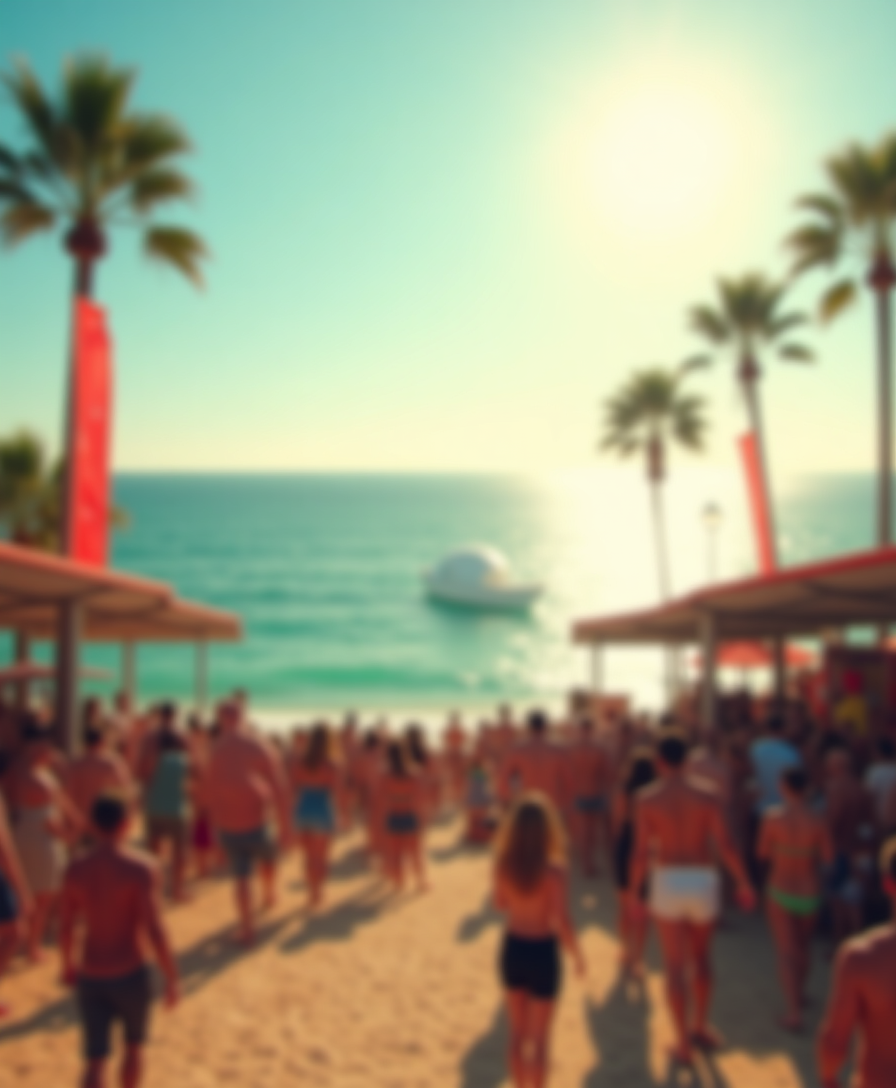

In [12]:

# 🖼️ Replicate로 4:5 포스터 배경 생성
import replicate, requests
from PIL import Image
from io import BytesIO
from pathlib import Path
from datetime import datetime
from IPython.display import display

MODEL_ID     = "black-forest-labs/flux-dev"
ASPECT_RATIO = "4:5"
NUM_IMAGES   = 1

def _save_image_from_url(url: str, base_name: str) -> Path:
    r = requests.get(url, timeout=60)
    r.raise_for_status()
    img = Image.open(BytesIO(r.content)).convert("RGB")
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    safe = "".join(ch if ch.isalnum() else "_" for ch in base_name)[:60]
    path = OUT_DIR / f"{safe}_{ts}.png"
    img.save(path, format="PNG")
    return path

def _save_image_from_bytes(data: bytes, base_name: str) -> Path:
    img = Image.open(BytesIO(data)).convert("RGB")
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    safe = "".join(ch if ch.isalnum() else "_" for ch in base_name)[:60]
    path = OUT_DIR / f"{safe}_{ts}.png"
    img.save(path, format="PNG")
    return path

def generate_with_replicate(prompt: str, name_for_file: str) -> list:
    try:
        outputs = replicate.run(MODEL_ID, input={
            "prompt": prompt,
            "aspect_ratio": ASPECT_RATIO,
            "num_outputs": NUM_IMAGES,
            "output_format": "png",
        })
    except Exception as e:
        print("[warn] aspect_ratio 실패 → width/height 폴백:", e)
        outputs = replicate.run(MODEL_ID, input={
            "prompt": prompt,
            "width": 1152, "height": 1440,  # 4:5
            "num_outputs": NUM_IMAGES,
        })

    saved = []
    if not isinstance(outputs, (list, tuple)):
        outputs = [outputs]
    for out in outputs:
        try:
            if isinstance(out, str) and out.startswith("http"):
                p = _save_image_from_url(out, name_for_file)
                saved.append(p); continue
            data = None
            if hasattr(out, "read"):
                data = out.read()
            elif isinstance(out, (bytes, bytearray)):
                data = bytes(out)
            elif isinstance(out, dict) and "uri" in out:
                p = _save_image_from_url(out["uri"], name_for_file)
                saved.append(p); continue
            if data:
                p = _save_image_from_bytes(data, name_for_file)
                saved.append(p)
        except Exception as e:
            print("[warn] 이미지 저장 실패:", e)
    return saved

prompt = info["prompt"]
print("\nReplicate 호출 시작...")
paths = generate_with_replicate(prompt, festival_name)
print("생성 파일:", [str(p) for p in paths])
for p in paths:
    display(Image.open(p))


In [13]:

# 🗂️ 메타데이터 저장
import json
meta = {
    "festival_name": festival_name,
    "inference": {k:v for k,v in info.items() if k != "prompt"},
    "prompt": info["prompt"],
    "model": "black-forest-labs/flux-dev",
    "aspect_ratio": "4:5",
    "num_images": 1,
    "outputs": [str(p) for p in paths],
}
from pathlib import Path
meta_path = Path("poster_name_only") / "name_only_generation_meta.json"
meta_path.write_text(json.dumps(meta, ensure_ascii=False, indent=2), encoding="utf-8")
print("메타 저장:", meta_path.resolve())


메타 저장: C:\workspace\uv_festival\poster_name_only\name_only_generation_meta.json
